# **<center>Asking Questions and Analyzing Section</center>**

## **_00. Import necessary libraries:_**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

pd.set_option('display.max_columns', None)

## **_01. Asking Meaningfull Questions:_**

### **_01.1. Question number 1: `What is the distribution of customer on avarage spending money and most favourite item by demographics?`_**

- **Nội dung**: Phân bố khách hàng theo độ tuổi và giới tính, số tiền mua trung bình theo nhóm tuổi hoặc giới tính và các loại sản phẩm phổ biến nhất ở các nhóm tuổi hoặc giới tính khác nhau.
- **Mục đích**: Chúng ta sẽ hiểu hơn về khách hàng, một số yếu tố như độ tuổi, giới tính và loại sản phẩm có thể tác động mạnh tới doanh thu công ty Fashion Campus.
- **Phân tích**:
    - Phân tích phân bố của khách hàng theo độ tuổi và giới tính, từ đó chúng ta so sánh độ lệch trong biểu đồ histogram và chênh lệch giữa các giới tính
    - Xác định số tiền mua trung bình theo nhóm tuổi hoặc giới tính, tại trong dữ liệu của chúng ta sẽ có nhiều lứa tuổi, vì vậy việc phân tích thành các cụm là rất cần thiết.
    - Xác định những sản phẩm nào được mua phổ biến theo từng nhóm tuổi


### **_01.2. Question number 2: `Which products are more inclined to be bought together?`_**

- **Nội dung**: Phân tích những sản phẩm hoặc nhóm sản phẩm thường xuyên mua cùng nhau bằng thuật toán `Apriori` từ đó đề xuất các sản phẩm bổ sung dựa trên lịch sử mua hàng của khách hàng.
- **Mục đích**: Tối ưu hóa chiến dịch tiếp thị, doanh nghiệp có thể xác định những chiến dịch tiếp thị hiệu quả nhất bằng cách tìm ra những quy luật kết hợp giữa các sản phẩm hoặc dịch vụ mà khách hàng thường mua. Điều này giúp tối ưu hóa ngân sách tiếp thị và tạo ra chiến dịch hiệu quả hơn.
- **Phân tích**:
    - Đầu tiên chúng ta cần hiểu một số thông tin về thuật toán Apriori.
    - Kiểm tra các sản phẩm được mua với số lượng như thế nào.
    - Sử dụng thuật toán Apriori cùng với các chỉ số như min_suport, min_threshold để phân tích tính liên kết các sản phẩm trong Fashion Campus
    - Trực quan hóa các liên kết từ đó đánh giá được mối quan hệ giữa các sản phẩm.

### **_01.3. Question number 3_**

### **_01.4. Question number 4: `How do monthly or weekly sales trends manifest in the total sales figures? Are there forecasts for future sales?`_**

- **Nội dung**: Chúng ta sẽ xác định xu hướng hàng tháng hoặc hàng tuần trong tổng doanh số bán hàng, từ đó dự đoán ra doanh số bán hàng qua mô hình Arima. Ngoài ra chúng ta sẽ xem xét ngành hàng nào được bán chạy nhất theo thời gian.
- **Mục đích**: Dự đoán được doanh thu của công ty từ đó có thể đưa ra các chiến lược bán hàng hợp lý
   => ta nhận thấy lượng toltal sales tăng dần theo năm, tuy nhiên đến giữa khoảng 2022 có dấu hiệu đi xuống, vì thế chúng tôi tập trung đẩy mạnh vào marketing nhằm nâng cao doanh thu mua hàng
- **Phân tích**:
    - Xử lý những giao dịch thành công hoặc thất bại trong `payment_status`
    - Xác định khoảng thời gian nào khách hàng mua hàng nhiều nhất
    - Phân tích doanh thu theo khoảng thời gian như ngày, tuần, tháng.
    - Sử dụng mô hình Arima để dự đoán doanh số 
    - Phân tích xu hướng lợi nhuận theo thời gian của từng ngành hàng

## **_02. Input Data and Pre-processing Data:_**

Phần code này thực hiện:
- Thực hiện lại tiền xử lý cho ba bộ dữ liệu `product`, `customer`, `transaction`

**Đọc dữ liệu cho transaction_new**

In [2]:
# Đọc dữ liệu transaction
df_transaction = pd.read_csv('Data/transaction_new.csv')
df_transaction.head(2)

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price
0,2018-07-29T15:22:01.458193Z,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03T05:07:24.812676Z,-8.227893,111.969107,199832,54728,1,191247
1,2018-07-30T12:40:22.365620Z,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526,16193,1,145526


**Tiền xử lí cho customer**

In [3]:
df_customer = pd.read_csv("Data/customer.csv")
# Chuyển dữ liệu thời gian về đúng kiểu dữ liệu
df_customer['first_join_date'] = pd.to_datetime(df_customer['first_join_date'])
df_customer['birthdate'] = pd.to_datetime(df_customer['birthdate'])

df_customer.head(2)

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date
0,2870,Lala,Maryati,671a0865-ac4e-4dc4-9c4f-c286a1176f7e,671a0865_ac4e_4dc4_9c4f_c286a1176f7e@startupca...,F,1996-06-14,iOS,c9c0de76-0a6c-4ac2-843f-65264ab9fe63,iPhone; CPU iPhone OS 14_2_1 like Mac OS X,-1.043345,101.360523,Sumatera Barat,Indonesia,2019-07-21
1,8193,Maimunah,Laksmiwati,83be2ba7-8133-48a4-bbcb-b46a2762473f,83be2ba7_8133_48a4_bbcb_b46a2762473f@zakyfound...,F,1993-08-16,Android,fb331c3d-f42e-40fe-afe2-b4b73a8a6e25,Android 2.2.1,-6.212489,106.818850,Jakarta Raya,Indonesia,2017-07-16


**Tiền xử lí cho product**

In [4]:
df_product = pd.read_csv("Data/product.csv")
# rename: Đổi tên cột
df_product = df_product.rename(columns = {'id' : 'product_id'})
df_product.head(2)

,product_id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans


## **_03. Analyzing Data to Answer each Question:_**

### **_03.1. Question number 1: `What is the distribution of customer on avarage spending money and most favourite item by demographics?_**

#### **_03.1.1. Pre-process Data:_**

  - Phân bố khách hàng theo độ tuổi và giới tính.
  - Số tiền mua trung bình theo nhóm tuổi hoặc giới tính.
  - Các loại sản phẩm phổ biến nhất ở các nhóm tuổi hoặc giới tính khác nhau.

**Tạo cột mới**

Tạo cột `Age` cho df_customer: Hiện tại chúng ta đã có cột `birthdate` tức ngày sinh của khách hàng, vì vậy chúng ta sẽ tính tuổi bằng cách lấy thời điểm hiện tại trừ cho ngày sinh của khách hàng.

In [ ]:
from datetime import datetime

df_customer['Age'] = ((datetime.now() - df_customer['birthdate']).dt.days / 365.25).round().astype(np.int64)

**Biểu đồ phân bố khách hàng theo độ tuổi và giới tính.**

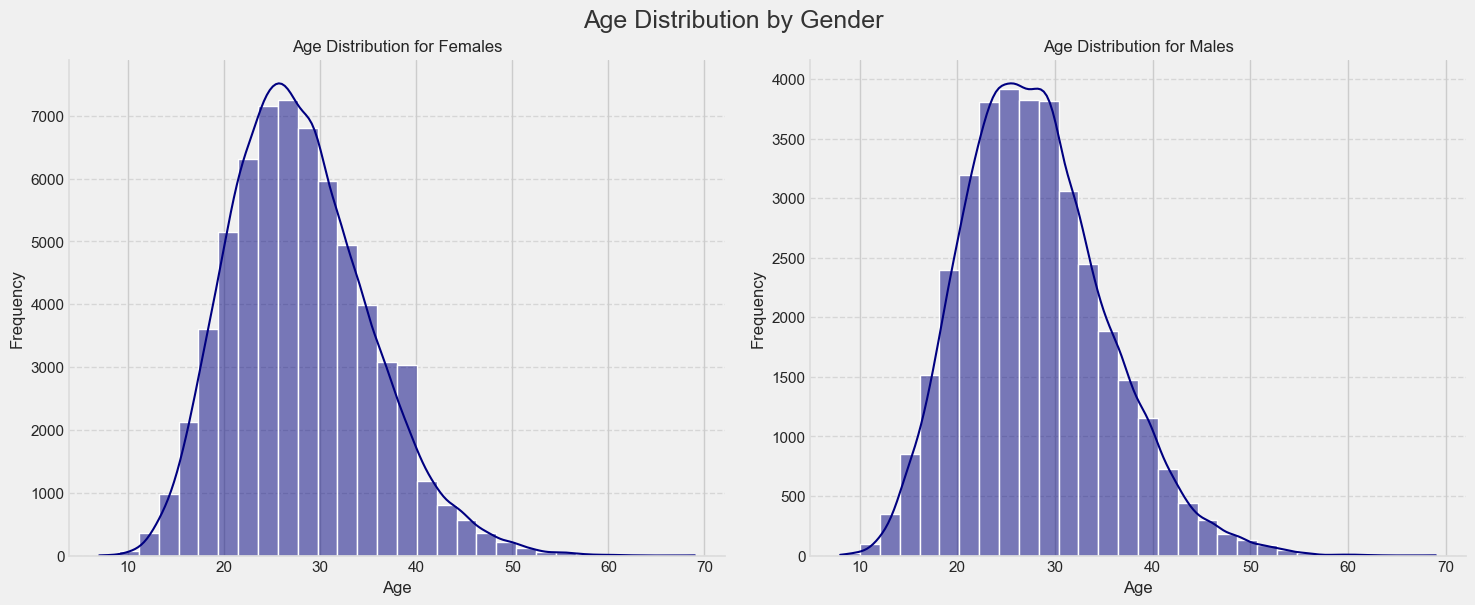

In [ ]:
# Set a visually pleasing style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for Gender F
sns.histplot(data=df_customer[df_customer['gender'] == 'F'], x="Age", color='navy', kde=True, ax=axes[0], bins=30)
axes[0].set(title='Age Distribution for Females', xlabel='Age', ylabel='Frequency')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for Gender M
sns.histplot(data=df_customer[df_customer['gender'] == 'M'], x="Age", color='navy', kde=True, ax=axes[1], bins=30)
axes[1].set(title='Age Distribution for Males', xlabel='Age', ylabel='Frequency')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Customize background color
fig.set_facecolor('#f0f0f0')
axes[0].set_facecolor('#f0f0f0')
axes[1].set_facecolor('#f0f0f0')

# Adjust layout
plt.tight_layout()

# Add a title for the entire figure
plt.suptitle('Age Distribution by Gender', fontsize=18, y=1.02, color='#333333')

# Remove spines
sns.despine()

# Add a subtle gray border to the plots
for ax in axes:
    ax.spines['top'].set_color('#dddddd')
    ax.spines['right'].set_color('#dddddd')
    ax.spines['bottom'].set_color('#dddddd')
    ax.spines['left'].set_color('#dddddd')

# Customize tick parameters
for ax in axes:
    ax.tick_params(axis='both', which='both', length=0)

# Show the plots
plt.show()

- Chúng ta có thể thấy rằng qua biểu đồ histogram thì giới tính Nam và Nữ không có sự khác nhau nhiều.
- Độ tuổi từ 20 - 35 là khoảng thời gian mua hàng nhiều nhất của cả hai giới tính
- Cả hai biểu đồ đều có dạng phân phối chuẩn

### **_03.2. Question number 2_**

### **_03.3. Question number 3_**

### **_03.4. Question number 4_**

## **_04. Reflection:_**